## Getting Spark ready

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.6.tgz
!tar xf spark-2.4.8-bin-hadoop2.6.tgz
!rm -rf spark-2.4.8-bin-hadoop2.7.tgz*
!pip -q install findspark graphframes

     |████████████████████████████████| 163kB 9.8MB/s 


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.6"

os.environ["HADOOP_HOME"] = os.environ["SPARK_HOME"]
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.0-spark2.4-s_2.11 pyspark-shell"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

## Part 1

#### Read from files

Vertices and Edges are read from the text files with appropriate column names

output shows created schemas and tables for both files

In [4]:
from pyspark.sql.functions import col, split, substring, length

split_col = split(col('value'), '\t')

# Create a Vertex DataFrame
v = spark.read.text('Vertex.txt')
v = v.withColumn("id",split_col.getItem(0)) \
    .withColumn("name",split_col.getItem(1)) \
    .drop("value")   

v.printSchema()
v.show(5, truncate = False)

# Create an Edge DataFrame with "src" and "dst" columns
e = spark.read.text('edges.txt')
e = e.withColumn("src",split_col.getItem(0)) \
    .withColumn("dst",split_col.getItem(1)) \
    .drop("value")   

e.printSchema()
e.show(5, truncate = False)

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)

+-------------------+---------------------------------------------------+
|id                 |name                                               |
+-------------------+---------------------------------------------------+
|8774773382640701231|List of Canadian Football League records (team)    |
|7761101435592530731|List of Football Associations by date of foundation|
|8133629125642450577|Template:2004 Football HOF                         |
|7698287352205296646|File:North Melbourne Football Club Logo.png        |
|2097725138520422255|Georgia Football Federation                        |
+-------------------+---------------------------------------------------+
only showing top 5 rows

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)

+-------------------+-------------------+
|src                |dst                |
+-------------------+-------------------+
|3205189634386258258|5457500977

#### Create graph

Simply create GraphFrame with V and E dataframes

In [5]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


## Part 2

#### inDegrees is already implemented by graphframes

inDegrees are found and sorted in descending order. To see the name of the nodes we need to join the result with vertices on id

output shows the node with biggest inDegree

In [6]:
# Get in-degree of each vertex, 
# sort it, join it with vertices to extract name of paper, 
# show the first one
g.inDegrees \
  .orderBy(col('inDegree').desc()) \
  .join(g.vertices, 'id') \
  .show(1, truncate = False) \

+------------------+--------+-------------------+
|id                |inDegree|name               |
+------------------+--------+-------------------+
|946065507707541358|327     |The Football League|
+------------------+--------+-------------------+
only showing top 1 row



#### I implemented outDegrees

outDegrees is implemented by counting 'src' groups in edges. The rest is like the previous code

In [7]:
# in edges, group by source node and count outdegree
# sort it, join it with vertices to extract name of paper, 
# show the first one
g.edges \
  .groupBy('src').count() \
  .withColumn('outDegree', col('count')).drop('count') \
  .orderBy(col('count').desc()) \
  .join(g.vertices) \
  .filter(col('src') == col('id')).drop('src') \
  .show(1, truncate = False) \

+---------+-------------------+-------------------------------------------------+
|outDegree|id                 |name                                             |
+---------+-------------------+-------------------------------------------------+
|264      |3841755165517709241|Template:All-Ireland Senior Football Championship|
+---------+-------------------+-------------------------------------------------+
only showing top 1 row



## Part 3

Spark requires us to set a checkpoint directory in order to get connected components. 

The table bellow tells us which component each node belongs to.

In [8]:
spark.sparkContext.setCheckpointDir('graphframes_cps')

cC = g.connectedComponents()
cC.show()

+-------------------+--------------------+-------------+
|                 id|                name|    component|
+-------------------+--------------------+-------------+
|8774773382640701231|List of Canadian ...|            1|
|7761101435592530731|List of Football ...|            1|
|8133629125642450577|Template:2004 Foo...|            1|
|7698287352205296646|File:North Melbou...|            1|
|2097725138520422255|Georgia Football ...| 103079215111|
|6922631041164063688|Football at the 2...|            1|
|1197038737428485418|Wikipedia:Miscell...| 137438953474|
|2558316557265591251|Football at the 2...|            1|
|1775630591844818068|Serbian Football ...|            1|
|4205664098526595262|Wikipedia:WikiPro...|            1|
|1033687574081081174|1943–44 Netherlan...|   8589934631|
|6862802626977892137|1948–49 Football ...|            1|
|3681282860489534792|1998–99 North Wes...|            1|
|8747320282862100730|1984–85 Football ...|            1|
|7895242920481704787|Template:1

By a simple aggregation on component column, we can find the size of each component

In [9]:
cC.groupBy('component').count() \
  .orderBy(col('count').desc()) \
  .show()

+-------------+-----+
|    component|count|
+-------------+-----+
|            1| 6477|
|  42949672979|   52|
|  85899345921|   35|
|   8589934631|   14|
| 163208757270|   14|
|  77309411351|   13|
| 317827579922|   13|
|  68719476736|   12|
|  68719476765|   11|
|  34359738381|    9|
| 154618822695|    7|
|  17179869223|    7|
| 687194767374|    6|
| 292057776177|    6|
| 420906795013|    6|
| 137438953508|    6|
| 146028888100|    6|
| 446676598817|    6|
|1108101562411|    5|
| 730144440335|    5|
+-------------+-----+
only showing top 20 rows



## Part 4

This part is very similar to Part 2! only instead of showing the top result, I show top 10 results...

In [10]:
# Get in-degree of each vertex, 
# sort it, join it with vertices to extract name of paper, 
# show the first one
g.inDegrees \
  .orderBy(col('inDegree').desc()) \
  .join(g.vertices, 'id') \
  .show(10, truncate = False) \

+-------------------+--------+----------------------------------------+
|id                 |inDegree|name                                    |
+-------------------+--------+----------------------------------------+
|946065507707541358 |327     |The Football League                     |
|3856212023725725593|322     |National Football League                |
|8978262722425160811|316     |Australian Football League              |
|6245498229508734555|185     |Southern Football League                |
|7264519433548233535|180     |Football League First Division          |
|5362090331808156011|179     |Football League Second Division         |
|277710621679830671 |149     |All-Ireland Senior Football Championship|
|1984578398767042266|145     |Scottish Football League                |
|2395551540800395672|134     |Football League Third Division          |
|5395033957924805072|130     |Pro Football Hall of Fame               |
+-------------------+--------+----------------------------------

## Part 5

installing nessecery packages

In [11]:
pip install plotly

In [12]:
pip install networkx

by using networkx library, I only convert the edges to a list of tuples and pass it to networkx graph and then plot it!

Because our graph is very big and convoluted, I refuse to show node labels

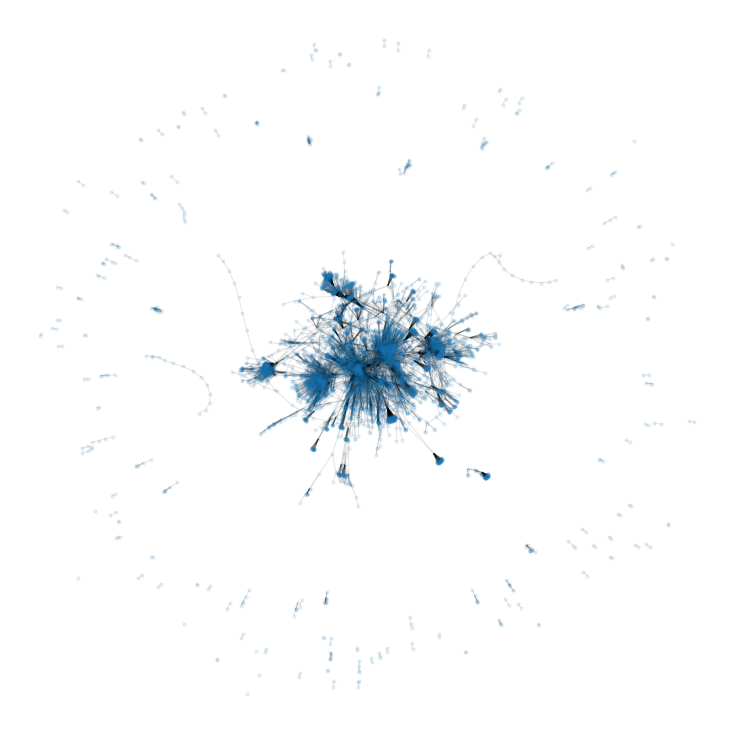

In [21]:
# Import packages for data visualization
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10, 10))

G = nx.Graph()
G.add_edges_from(list(g.edges.toPandas().to_records(index=False)), weight=1)

nx.draw(G, with_labels=False, alpha=0.1, node_size= 10)